In [2]:
using Plots
using LaTeXStrings

target(x::Float64) = (x^3-15*x^2+7*x+1)/10
target_ravine(p) = sum(p .* p)
target_ravine_2(p) = p[1]^2 + 100*p[2]^2
simplex_test_func(x) = 3*(x[1]-5)^2 + 7*(x[2]-10)^2
fly_func(x) = (x[1]-2*x[2])^2 + (x[2]-9)^2
function target_rastrygin(p)
    A = 10
    result = A*length(p)
    for idx in 1:length(p)
        result += p[idx]^2 - A*cos(2*pi*p[idx])
    end
    return result
end
function target_schefill(p)
    A = 418.9829
    result = A*length(p)
    for idx in 1:length(p)
        result -= p[idx]*sin(sqrt(abs(p[idx])))
    end
    return result
end
target_rosenbrock(p) = (1 - p[1])^2 + 100*(p[2] - p[1]^2)^2

global Lf_max=0
function df(f, points)
    result = []
    for idx in 2:length(points)-1
        push!(result, (f(points[idx+1]) - f(points[idx-1]))/(points[idx+1]-points[idx-1]))
        global Lf_max = max(Lf_max, max(abs(result[end])))
    end
    return result
end

function grad(f, x, eps=1e-6)
    result = zeros(length(x))
    for i in 1:length(x)
        next_x = copy(x)
        next_x[i] += eps
        result[i] = (f(next_x) - f(x)) / eps
    end
    return result
end

function hess(func, x, eps=1.e-6)
    __sz = length(x)
    result = zeros(__sz, __sz)
    for i in 1:__sz
        for j in 1:__sz
            next_x_i = copy(x)
            next_x_i[i] += eps
            next_x_j = copy(x)
            next_x_j[j] += eps
            next_x_ij = copy(x)
            next_x_ij[i] += eps
            next_x_ij[j] += eps
            result[i,j] = (func(next_x_ij) - func(next_x_j) - func(next_x_j) + func(x))/eps^2 
        end
    end
    return result
end

function ddf(f, points)
    result = []
    for idx in 2:length(points)-1
        push!(result, (f(points[idx+1]) - 2 * f(points[idx]) + f(points[idx-1]))/(points[idx+1]-points[idx])^2)
    end
    return result
end

function ddf_with_points(f, points)
    result = []
    for idx in 2:length(points)-1
        push!(result, (f(points[idx+1]) - 2 * f(points[idx]) + f(points[idx-1]))/(points[idx+1]-points[idx])^2)
    end
    return result, points[2:length(points)-1]
end

function get_fib(n)
    sqrt5 = sqrt(5)
    trunc(Int, (1 / sqrt5) * (((1 + sqrt5) / 2)^n - ((1  - sqrt5) / 2)^n))
end

function is_unimodal_df(f, a, b, N=1000)
    deriv = df(f, range(a, b, N))
    last_deriv = deriv[1]
    for current_deriv in deriv[2:length(deriv)-1]
        if current_deriv <= last_deriv
            return false
        end
    end
    return true
end

function is_unimodal_ddf(f, a, b, N=1000)
    for current_deriv in ddf(f, range(a, b, N))
        if current_deriv < 0
            return false
        end
    end
    return true
end

function search_unimodal_segment(f, a, b, N=1000)
    deriv, points = ddf_with_points(f, range(a, b, N))
    interval_start, interval_end = nothing, nothing
    result_start, result_end = nothing, nothing
    for (second_deriv, point) in zip(deriv, points)
        if second_deriv < 0
            if interval_start != nothing
                if (interval_end - interval_start) > (result_end - result_start)
                    result_start, result_end = interval_start, interval_end
                end
                interval_start = nothing
                interval_end = nothing
            end
        elseif second_deriv > 0
            if interval_start == nothing
                interval_start = point
            end
            interval_end = point
        end
    end
    if result_end == nothing || result_start == nothing
        return interval_start, interval_end    
    end
    if (interval_end - interval_start) > (result_end - result_start)
        result_start, result_end = interval_start, interval_end
    end
    return result_start, result_end
end

function nnorm(p)
    return sqrt(sum(p .* p))
end

nnorm (generic function with 1 method)

In [33]:
function function_min_iter(f, start, stop, n)
    dots = []
    step = (stop - start) / n
    min_value = f(start)
    min_point = start
    for i in 1:n
        x = start + i * step
        append!(dots, x)
        if f(x) < min_value
            min_value = f(x)
            min_point = x
        end
    end
    error = (stop - start)/n
    return min_point, dots, error, n
end

function function_min_dyhotomy(f, a, b, eps=1.e-6)
    dots = []
    iter = 0
    while abs(b - a) > eps
        iter += 1
        mid = (a + b) / 2
        f1 = f(mid - eps)
        f2 = f(mid + eps)
        append!(dots, mid - eps)
        append!(dots, mid + eps)
        if f1 < f2
            b = mid
        else
            a = mid
        end
    end
    error = Lf_max * eps / 2
    return (a + b) / 2, dots, error, iter
end

function function_min_dyhotomy_impl(f, a, b, eps=1.e-6)
    while abs(b - a) > eps
        mid = (a + b) / 2
        f1 = f(mid - eps)
        f2 = f(mid + eps)
        if f1 < f2
            b = mid
        else
            a = mid
        end
    end
    return (a + b) / 2
end

function function_min_golden(f, start, stop, eps=1.e-6)
    phi = (sqrt(5.0) - 1) / 2
    dots = []
    iter = 0
    while abs(stop - start) > eps
        iter += 1
        c = stop - (stop - start) * phi
        d = start + (stop - start) * phi
        append!(dots, c)
        append!(dots, d)
        if f(c) < f(d)
            stop = d
        else
            start = c
        end
    end
    error = Lf_max * phi * eps
    return (start + stop) / 2, dots, error, iter
end

function function_min_fib(f, a, b, n, eps=1.e-6)
    x1 = a + (get_fib(n) / get_fib(n + 2)) * (b - a)
    x2 = a + b - x1
    y1 = f(x1)
    y2 = f(x2)
    dots = []
    iter = 0
    while abs(b - a) > eps
        iter += 1
        if y1 <= y2
            b = x2
            x2 = x1
            x1 = a + b - x1
            y2 = y1
            y1 = f(x1)
        else
            a = x1
            x1 = x2
            x2 = a + b - x2
            y1 = y2
            y2 = f(x2)
        end

        append!(dots, (a + b) / 2)
    end
    error = Lf_max * eps
    return (a + b) / 2, dots, error, iter
end

function_min_fib (generic function with 2 methods)

In [32]:
function sven_localization(f, x_0, h = 0.01)
    x_i = []
    x_0 = copy(x_0)
    push!(x_i, x_0)
    direction = 1
    x = x_0 + direction * h
    if f(x) > f(x_0)
        direction = -1
        x = x_0 + direction * h
    end
    push!(x_i, x)
    while f(x + direction * h) < f(x)
        h *= 2
        buf = x_0
        x_0 = x
        x = buf + direction * h
        push!(x_i, x)
    end
    if size(x_i)[1] > 2
        return minmax(x_i[end], x_i[lastindex(x_i) - 1])
    else
        return minmax(x_i[end], x_i[lastindex(x_i) - 1])
    end
    
end

function one_dim_optimize(f, x_0=0.0)
    a, b = sven_localization(f, x_0)
    x_opt = function_min_dyhotomy_impl(f, a, b) 
    return x_opt
end

function one_dim_optimize_test(f, x_0=0.0)
    a = -2*x_0
    b = 2*x_0
    x_opt = function_min_dyhotomy_impl(f, a, b) 
    return x_opt
end

function one_dim_optimize_test2(f; a=0.0, b=1.0)
    x_opt = function_min_dyhotomy_impl(f, a, b)
    return x_opt
end

function coordinate_descent(f, x_0, h_0, eps = 1e-6)
    alpha = h_0
    x = [x_0]
    k = 0
    while true
        x_min = copy(x[end])
        k += 1

        for i in 1:length(x_0)
            e_k = x[end][i] / norm(x[end])
            x_i_new_1 = x[end][i] + alpha * e_k
            x_i_new_2 = x[end][i] - alpha * e_k

            x_candidate = copy(x[end])

            x_candidate[i] = x_i_new_1
            if f(x_min) > f(x_candidate)
                x_min = x_candidate
            end

            x_candidate[i] = x_i_new_2
            if f(x_min) > f(x_candidate)
                x_min = x_candidate
            end
        end
        if norm(x_min - x[end]) < eps
            break
        end
        if f(x_min) < f(x[end])
            push!(x, x_min)
        else
            alpha = alpha * 0.5
        end   
        
        if length(x) > 1 && norm(x[end] - x[end-1]) < eps
            break
        end
    end
    return x[end], k, x
end

function hooke_jeeves_method(f, x_0, h_0, eps = 1e-6)
    alpha = h_0
    x = [x_0]
    k = 0
    points_added = 1
    while true
        x_min = copy(x[end])
        k += 1
        
        if points_added > 0 && points_added == 3
            points_added = 1
            x0 = copy(x[lastindex(x) - 2])
            x1 = copy(x[lastindex(x) - 1])
            x2 = copy(x[end])
            x_min = 2*x2-x0
            push!(x, x_min)
        end        
            
        for i in 1:length(x_0)
            x_i_new_1 = x[end][i] + alpha
            x_i_new_2 = x[end][i] - alpha
            x_candidate = copy(x[end])
            x_candidate[i] = x_i_new_1
            if f(x_min) > f(x_candidate)
                x_min = copy(x_candidate)
            end
            x_candidate[i] = x_i_new_2
            if f(x_min) > f(x_candidate)
                x_min = copy(x_candidate)
            end
        end
        
        if norm(x_min - x[end]) < eps
            break
        end
        if f(x_min) < f(x[end])
            push!(x, x_min)
            points_added+=1 
        else
            alpha *= 0.5 
        end   
        if length(x) > 1 && norm(x[end] - x[end-1]) < eps
            break
        end
        
    end
    return x[end], k, x
end

function Gauss_Zeidel(f, x_0, h_0, eps = 1e-6)
    alpha = h_0
    x = [x_0]
    k = 0
    while true 
        k += 1
        x_min = copy(x[end])
        for i in 1:length(x_0)
            x_candidate = copy(x[end])
            
            e_k = zeros(length(x_0))
            e_k[i] = x_candidate[i] / norm(x_candidate)
        
            g(a) = f(x_candidate + a*e_k)
            alpha_new = one_dim_optimize(g, alpha)
            x_new_i_1 = x_candidate + alpha_new * e_k
            x_new_i_2 = x_candidate - alpha_new * e_k

            if f(x_min) > f(x_new_i_1)
                x_min = x_new_i_1
                alpha = alpha_new
            end

            if f(x_min) > f(x_new_i_2)
                x_min = x_new_i_2
                alpha = alpha_new
            end
        end
        push!(x, x_min)
        if length(x) > 1 && norm(x[end] - x[end-1]) < eps
            break
        end
    end
    return x[end], k, x
end

Gauss_Zeidel (generic function with 2 methods)

In [31]:
function simplex_method(f, eps=1e-6, max_iter=1000)
    x = [ [0.0, 0.0], [(sqrt(3)+1)/(2*sqrt(2)), (sqrt(3)-1)/(2*sqrt(2))], [(sqrt(3)-1)/(2*sqrt(2)), (sqrt(3)+1)/(2*sqrt(2))]]
    triangles = [copy(x)]
    x_4 = []
    iterations = 0
    for idx in 1:max_iter
        if(f(x[2]) >= f(x[1]) && f(x[2]) >= f(x[3]))
            temp = x[1]
            x[1] = x[2]
            x[2] = temp
        elseif (f(x[3]) >= f(x[1]) && f(x[3]) >= f(x[2]))
            temp = x[1]
            x[1] = x[3]
            x[3] = temp
        end
        x4 = x[2] + x[3] - x[1]
        push!(x_4, x4)
        if(f(x4) >= f(x[2]) && f(x4) >= f(x[3]))
            x[1] = x4
            x[2] = x4+(x[2] - x4)/2
            x[3] = x4+(x[3] - x4)/2
            push!(triangles, [x4, x[2], x[3]])
        else
            x[1] = x4
            push!(triangles, [x4, x[2], x[3]])
        end
        iterations = idx
        if norm(x[1]- x[2]) < 1e-3
            break
        end
    end
    return x[1], iterations, triangles, x_4
end

# отражение, сжатие, растяжение
function nelder_mead(f, eps=1e-6, max_iter=1000, alpha=1, beta=0.5, gamma=2)
    x = [ [0.0, 0.0], [(sqrt(3)+1)/(2*sqrt(2)), (sqrt(3)-1)/(2*sqrt(2))], [(sqrt(3)-1)/(2*sqrt(2)), (sqrt(3)+1)/(2*sqrt(2))]]
    trajectory = []
    mid = []
    x_4 = []
    x_5 = []
    trac = []
    iterations = 0
    for idx in 1:max_iter
        x = sort(x, by = x->f(x), rev=true)
        push!(trajectory, x[3])
        trajectory = vcat(trajectory, x) 
        x_mid = (x[2] + x[3]) / 2
        x4 = x_mid + alpha * (x_mid - x[1])
        
        push!(mid, x_mid)
        push!(x_4, x4)
        push!(trac, x[1], x4)

        if f(x4) < f(x[3])
            # a)
            # Значение в отображенной точке (x4) меньше наилучшего из x
            # Растягиваем симлекс с gamma = 2
            x5 = gamma * x4 + (1 - gamma) * x_mid
            x[1] = (f(x5) < f(x4)) ? x5 : x4 
            push!(x_5, x5)
            push!(trac, x[1], x5)
        else
            # b)
            if f(x[3]) < f(x4) < f(x[2])
                # Значение в отображенной точке x4 больше наилучшего, но меньше среднего x2
                x[1] = x4
            else
                if f(x[2]) < f(x4) < f(x[1])
                    # Значение в отображенной точке x4 больше среднего, но меньше наихудшего x1
                    x[1] = x4
                end
                
                x = sort(x, by = x->f(x), rev=true)
                x5 = (x[1] +  x_mid) / 2
                if f(x5) < f(x[1])
                    # Точка сжатаго симплекса меньше наихудшей точки симплекса - заменяем
                    x[1] = x5
                else
                    # c)
                    x[1] = x[3] + 1/2 * (x[1] - x[3])
                    x[2] = x[3] + 1/2 * (x[2] - x[3])
                end

                push!(x_5, x5)
                push!(trac, x[1], x5)   
            end
        end
        sort(x, by = x->f(x), rev=true)
        fx = [(f(vert) - f(x_mid))^2 for vert in x]
        if sqrt(sum(fx) / 3) < eps
            break
        end
        iterations = idx
    end
    
    return x[3], iterations, trajectory, mid, trac, x_4, x_5
end

function grad_descent(func, x0, alpha = 0.1, eps=1e-6, max_iter=1e3, func_eps=1e-6, grad_eps=1e-6)
    descent_rate = alpha  
    iterations = 0
    points = []
    push!(points, x0)
    while iterations < max_iter
        x = copy(points[end])
        gradient = grad(func, x)
        next_x = x - descent_rate * gradient
        if norm(next_x - x) <= eps || abs(func(next_x)-func(x)) <= func_eps || norm(gradient) <= grad_eps
            break
        end
        if func(next_x) < func(x)
            push!(points, next_x)
        else
            descent_rate /= 2
        end
        iterations+=1 
    end
    return points[end], iterations, points
end

grad_descent (generic function with 6 methods)

In [115]:
function fast_grad_descent(func, x0, alpha = 0.1, eps=1e-6, max_iter=1e3, func_eps=1e-6, grad_eps=1e-6)
    descent_rate = alpha
    iterations = 0
    points = []
    push!(points, x0)
    while iterations < max_iter
        x = copy(points[end])
        gradient = grad(func, x)
        g(a) = func(x - a*gradient)
        descent_rate = one_dim_optimize_test2(g)
        next_x = x - descent_rate * gradient
        if norm(next_x - x) <= eps
            break
        end
        push!(points, next_x)
        iterations+=1 
    end
    return points[end], iterations, points
end

function conj_grad_descent(func, x0, alpha = 0.1, eps=1e-6, max_iter=1e3, func_eps=1e-6, grad_eps=1e-6)
    descent_rate = alpha  
    iterations = 0
    points = []
    push!(points, x0)
    conj = grad(func, x0)
    while iterations < max_iter
        x = copy(points[end])
        g(a) = func(x - a*conj)
        descent_rate = one_dim_optimize(g, descent_rate)
        next_x = x - descent_rate * conj
        if norm(next_x - x) <= eps
            break
        end
        push!(points, next_x)
        new_grad = grad(func, next_x)
        conj = new_grad + norm(new_grad)^2/norm(grad(func, x))^2 * conj
        iterations+=1 
    end
    return points[end], iterations, points
end

conj_grad_descent (generic function with 6 methods)

In [38]:
using LinearAlgebra
function polak_ribiere(func, x0; alpha = 0.1, eps=1e-6, max_iter=1e3, func_eps=1e-6, grad_eps=1e-6, trace=true)
    descent_rate = alpha
    iterations = 0
    points = []
    if trace
        push!(points, x0)
    end
    x = copy(x0)
    p = grad(func, x0)
    while iterations < max_iter
        g(a) = func(x - a*p)
        func_grad = grad(func, x)
        descent_rate = one_dim_optimize_test(g, 1)
        next_x = x - descent_rate * p
        if norm(next_x - x) <= eps || norm(func_grad) < eps || abs(func(next_x) - func(x)) < func_eps
            break
        end
        if trace
            push!(points, next_x)
        end
        new_grad = grad(func, next_x)
        b = max(sum(new_grad .* (new_grad - func_grad))/norm(func_grad)^2, 0.0)
        x = copy(next_x)
        p = new_grad + b * p
        iterations+=1
    end
    return x, iterations, points
end

function hesten_stiffel(func, x0; alpha = 0.1, eps=1e-6, max_iter=1e3, func_eps=1e-6, grad_eps=1e-6, trace=true)
    descent_rate = alpha
    iterations = 0
    points = []
    if trace
        push!(points, x0)
    end
    x = copy(x0)
    p = -grad(func, x0)
    while iterations < max_iter
        g(a) = func(x + a*p)
        func_grad = grad(func, x)
        descent_rate = one_dim_optimize_test(g, 10)
        next_x = x + descent_rate * p
        if norm(next_x - x) <= eps || norm(func_grad) < eps || abs(func(next_x) - func(x)) < func_eps
            break
        end
        if trace
            push!(points, next_x)
        end
        new_grad = grad(func, next_x)
        b = max(-sum(new_grad .* (new_grad - func_grad))/sum(p .* (new_grad - func_grad)), 0.0)
        x = copy(next_x)
        p = beta == 0.0 ? -new_grad : -new_grad + b * p
        iterations+=1
    end
    return x, iterations, points
end

function dickson(func, x0; alpha = 0.1, eps=1e-6, max_iter=1e3, func_eps=1e-6, grad_eps=1e-6, trace=true)
    descent_rate = alpha
    iterations = 0
    points = []
    if trace
        push!(points, x0)
    end
    x = copy(x0)
    p = -grad(func, x)
    betas = [1.0]
    conj_points = [p]
    while iterations < max_iter
        func_grad = grad(func, x)
        g(a) = func(x + a*p)
        descent_rate = one_dim_optimize_test2(g, a=0, b=2)
        next_x = x + descent_rate * p
        if norm(next_x - x) <= eps || norm(func_grad) < eps || abs(func(next_x) - func(x)) < func_eps
            break
        end
        if trace
            push!(points, next_x)
        end
        new_grad = grad(func, next_x)
        x = copy(next_x)
        beta = max(-dot(new_grad, new_grad)/dot(p, func_grad), 0.0)
        p = - new_grad + beta .* p
        #p = - new_grad
        push!(betas, beta)
        push!(conj_points, p)
        iterations+=1
    end
    return x, iterations, points
end

function dayan(func, x0; alpha = 0.1, eps=1e-6, max_iter=1e3, func_eps=1e-6, grad_eps=1e-6, trace=true)
    descent_rate = alpha
    iterations = 0
    points = []
    if trace
        push!(points, x0)
    end
    x = copy(x0)
    p = -grad(func, x)
    betas = [1.0]
    conj_points = [p]
    while iterations < max_iter
        func_grad = grad(func, x)
        g(a) = func(x + a*p)
        descent_rate = one_dim_optimize_test2(g)
        next_x = x + descent_rate * p
        if norm(next_x - x) <= eps || norm(func_grad) < eps || abs(func(next_x) - func(x)) < func_eps
            break
        end
        if trace
            push!(points, next_x)
        end
        new_grad = grad(func, next_x)
        x = copy(next_x)
        beta = max(dot(new_grad, (new_grad - func_grad))/dot(p, (new_grad - func_grad)), 0.0)
        p = - new_grad + beta .* p
        push!(betas, beta)
        push!(conj_points, p)
        iterations+=1
    end
    return x, iterations, points
end

dayan (generic function with 1 method)

In [7]:
function NewtonMethod(func, x0, eps=1.e-6, max_iter=1000)
    x = x0
    iterations = 0
    path = [x0]
    for idx in 1:max_iter
        iterations+=1
        x = x - inv(hess(func, x)) * grad(func, x)
        push!(path, x)
        if norm(grad(func, x)) < eps
            break
        end
    end
    return x, iterations, path
end

function NewtonMethodWithLinearOpt(func, x0, eps=1.e-6, max_iter=1000)
    x = x0
    iterations = 0
    path = [x0]
    for idx in 1:max_iter
        iterations += 1
        func_grad = grad(func, x)
        hessian = hess(func, x)
        g(alpha) = func(x - alpha*inv(hessian)*func_grad)
        alpha_min = one_dim_optimize(g)
        x -= alpha_min * inv(hessian) * func_grad
        push!(path, x)
        if norm(grad(func, x)) < eps
            break
        end
    end
    return x, iterations, path
end

function NewtonMethodWithStaticHess(func, x0, eps=1.e-6, max_iter=1000)
    x = x0
    H = inv(hess(func, x0))
    iterations = 0
    path = [x0]
    for idx in 1:max_iter
        iterations += 1
        func_grad = grad(func, x)
        g(alpha) = func(x - alpha*H*func_grad)
        alpha_min = one_dim_optimize(g)
        x -= alpha_min * H * func_grad
        push!(path, x)
        if norm(grad(func, x)) < eps
            break
        end
    end
    return x, iterations, path
end

NewtonMethodWithStaticHess (generic function with 3 methods)

In [8]:
function square_approx(x0, x1, x2, y0, y1, y2)
    a0 = y0
    a1 = (y1 - y0) / (x1 - x0)
    a2 = 1 / (x2 - x1) * ((y2 - y0) / (x2 - x0) - (y1 - y0) / (x1 - x0)) 
    return (x1 + x0) / 2 - a1 / (2 * a2)
end

function Powell(func, x0, eps=1e-6, max_iter = 100, deltas=[0.1,0.1])
    x = [x0, copy(x0), copy(x0)]
    y = [0.0, 0.0, 0.0]
    x_opt = copy(x0)
    x_min = copy(x0)
    iterations = 0
    path = [x0]
    for idx in 1:max_iter
        best_x = x[1]
        for cord in 1:length(x0)
            x_opt = copy(x[1])
            x[2][cord] = x[1][cord] + deltas[cord]
            y[1] = func(x[1])   
            y[2] = func(x[2])
            if y[1] > y[2]
                x[3][cord] = x[1][cord] + 2 * deltas[cord]
            else
                x[3][cord] = x[1][cord] - deltas[cord]
            end
            y[3] = func(x[3])
            x_opt[cord] = square_approx(x[1][cord], x[2][cord], x[3][cord], y[1], y[2], y[3])
            y_min_idx = argmin(y)
            x_min = x[y_min_idx]
            push!(path, best_x)
            if func(x_min) < func(x_opt)
                best_x = x_min    
            else
                best_x = x_opt
            end
            x = [copy(best_x), copy(best_x), copy(best_x)]
        end
        iterations += 1
        if norm(x_opt - x_min) < eps
            break
        end 
    end
    
    return x_min, iterations, path
end

Powell (generic function with 4 methods)

In [43]:
function multicriteria_search(func, x0, n=10, eps1 = 1e-6, eps2 = 1e-6, max_iter=1000)
    iterations = 0
    points_diff = [0, 0]
    points = [x0]
    x = copy(x0)
    for idx in 1:max_iter
        iterations += 1
        points_diff = iterations % n+1 == 0 ? [0, 0] : points_diff
        func_grad = grad(func, x)
        if norm(func_grad) < eps1 || 0 < norm(points_diff) < eps2
            break
        end
        g(alpha) = func(x - alpha[1]*func_grad + alpha[2]*points_diff)
        #alpha, _, _ =  grad_descent(g, [0.0,0.0])
        alpha, _, _, _, _, _, _  =  nelder_mead(g)
        #alpha, _, _ =  fast_grad_descent(g, [0.0,0.0])
        #alpha, _, _ =  conj_grad_descent(g, x0)
        #alpha, _, _ =  NewtonMethod(g, x0)
        #alpha, _, _ =  NewtonMethodWithLinearOpt(g, x0)
        #alpha, _, _ =  NewtonMethodWithStaticHess(g, x0)
        new_x = x - alpha[1] * func_grad + alpha[2] * points_diff
        points_diff = new_x - x
        x = copy(new_x)
        push!(points, x)
    end
    return points[end], iterations, points
end
using Optim
function KreggLevi(func, x0; n=2, grad_eps =1e-6, coord_eps=1e-6,max_iter=10000)
    iterations = 0
    points_diff = fill([0., 0.], n)
    points = [x0]
    alpha = fill(grad_eps, n+1)
    x = copy(x0)
    da = alpha
    for idx in 1:max_iter
        iterations += 1
        func_grad = grad(func, x)
        if n!= 0 && (norm(func_grad) < grad_eps || 0 < (n == 0 ? coord_eps : norm(points_diff)) < coord_eps || norm(da) < grad_eps)
            break
        end
        if n == 0
            gz(alpha) = func(x - alpha*func_grad)
            new_alpha = [one_dim_optimize(gz, coord_eps)]
        else
            g(alpha) = func(x - alpha[1]*func_grad + sum(alpha[2:end].*points_diff))
            new_alpha, _, _ =  grad_descent(g, fill(0.0, n+1)) 
        end
        #alpha, _, _, _, _, _, _  =  nelder_mead(g)
        #new_alpha, _, _ =  fast_grad_descent(g, fill(coord_eps, n+1))
        #alpha, _, _ =  conj_grad_descent(g, x0)
        #new_alpha, _, _ =  NewtonMethod(g, fill(coord_eps, n+1))
        optim_result = Optim.optimize(g, fill(0.0, n+1))
        new_alpha = Optim.minimizer(optim_result)
        
        da = new_alpha - alpha
        alpha = copy(new_alpha)
        print("alpha: ($(alpha))\n")
        new_x = x - alpha[1] * func_grad + (n == 0 ? [0.,0.] : sum(alpha[2:end].*points_diff))
        if n == 0 && norm(new_x - x) < coord_eps
            break
        end
        if iterations <= n
            points_diff[iterations] = new_x - x
        elseif n != 0
            deleteat!(points_diff, 1)
            push!(points_diff, new_x - x)
        end
        x = copy(new_x)
        push!(points, x)
    end
    println("Iterations: $(iterations)")
    return points[end], iterations, points
end

function KreggLevi__impl(func, x0; n=2, grad_eps =1e-6, coord_eps=1e-6,max_iter=10000)
    iterations = 0
    points_diff = fill([0., 0.], n)
    points = [x0]
    alpha = fill(grad_eps, n+1)
    x = copy(x0)
    da = alpha
    if n == 0
        return fast_grad_descent(func, x0)
    end
    for idx in 1:max_iter
        iterations += 1
        func_grad = grad(func, x)
        if norm(func_grad) < grad_eps || 0 < norm(points_diff) < coord_eps || norm(da) < grad_eps
            break
        end
        g(alpha) = func(x - alpha[1]*func_grad + sum(alpha[2:end].*points_diff))
        new_alpha, _, _ =  grad_descent(g, fill(coord_eps, n+1))
        da = new_alpha - alpha
        alpha = copy(new_alpha)
        print("alpha: ($(alpha))\n")
        new_x = x - alpha[1] * func_grad + sum(alpha[2:end].*points_diff)
        if n == 0 && norm(new_x - x) < coord_eps
            break
        end
        if iterations <= n
            points_diff[iterations] = new_x - x
        elseif n != 0
            deleteat!(points_diff, 1)
            push!(points_diff, new_x - x)
        end
        x = copy(new_x)
        push!(points, x)
    end
    println("Iterations: $(iterations)")
    return points[end], iterations, points
end

KreggLevi__impl (generic function with 1 method)

In [10]:
function DFP(func, x0; coord_eps=1.e-6, grad_eps=1.e-6, max_iter=1000, renew_iter=20)
    x = x0
    n = I(length(x))
    p = -n*grad(func, x)
    iterations = 0
    points = [x]
    dx = [coord_eps, coord_eps]
    while norm(grad(func, x)) >= grad_eps && norm(dx) >= coord_eps && iterations < max_iter
        if (iterations+1) % renew_iter == 0
            n = I(length(x))
            p = -n*grad(func, x)
        end
        g(alpha) = func(x + alpha*p)
        alpha = one_dim_optimize(g, 0)
        next_x = x + alpha * p
        dx = next_x - x
        dg = grad(func, next_x) - grad(func, x)
        rho = 1 / dot(dg, dx)
        n = n + (dx*dx')/dot(dx,dg) - (n*(dg*dg')*transpose(n))/dot(dg,n*dg)
        p = - n * grad(func, next_x)
        x = next_x
        history = push!(points, x)
        iterations += 1
    end
    return x, iterations, points
end

function BFGS(func, x0; coord_eps=1.e-6, grad_eps=1.e-5, max_iter=1000)
    x = x0
    n = I(length(x))
    p = -n*grad(func, x)
    iterations = 0
    points = [x]
    dx = [coord_eps, coord_eps]
    while norm(grad(func, x)) >= grad_eps && norm(dx) >= coord_eps && iterations < max_iter
        println("Iter: $(iterations)\n pk: $(p)")
        g(alpha) = func(x + alpha*p)
        alpha = one_dim_optimize(g, 0)
        next_x = x + alpha * p
        dx = next_x - x
        dg = grad(func, next_x) - grad(func, x)
        rho = 1 / dot(dg, dx)
        n = (I - rho * (dx*dg')) * n * (I - rho * (dg*dx')) + rho * (dx * dx')
        p = - n * grad(func, next_x)
        x = next_x
        println(" alpha: $(alpha)\n xk+1: $(next_x)\n dx: $(dx)\n dg: $(dg)\n rho: $(rho)\n nu: $(n)\n pk+1: $(p)")
        history = push!(points, x)
        iterations += 1
    end
    return x, iterations, points
end

BFGS (generic function with 1 method)

In [74]:
function PSO(func, bounds; max_iter=1000, swarm_count=30, phi=[2.0,2.0], inertia_const=1., teleport_prob=0., eps=1e-5, stop_criterion=100)
    DIMS = 2
    bounds = minmax(bounds...)
    iterations = 0
    points = []
    swarms = [[bounds[1] + rand()*(bounds[2]-bounds[1]), bounds[1] + rand()*(bounds[2]-bounds[1])] for i in 1:swarm_count]
    swarms_speed = [zeros(DIMS) for i in 1:swarm_count]
    swarms_minimum = [zeros(DIMS) for i in 1:swarm_count]
    swarms_minimum_val = [Inf for i in 1:swarm_count]
    global_minimum = zeros(DIMS)
    global_minimum_val = Inf
    __stop_criterion = 0
    for idx in 1:max_iter
        iterations += 1
        for i in 1:length(swarms)
            if rand() < teleport_prob
                swarms_speed[i] = zeros(DIMS)
            end
            value = func(swarms[i])
            if value < swarms_minimum_val[i]
                swarms_minimum_val[i] = value
                swarms_minimum[i] = swarms[i]
            end
            if value < global_minimum_val
                global_minimum_val = value
                global_minimum = swarms[i]
            end
            r1, r2 = rand(DIMS), rand(DIMS)
            swarms_speed[i] = inertia_const .* swarms_speed[i] .+ phi[1] .* r1 .* (swarms_minimum[i] .- swarms[i]) + phi[2] .* r2 .* (global_minimum .- swarms[i])
            swarms[i] = clamp.(swarms[i] .+ swarms_speed[i], bounds...)
        end
        push!(points, global_minimum)
        __stop_criterion = length(points) > 2 && abs(func(points[end]) - func(points[end-1])) < eps ? __stop_criterion + 1 : 0 
        if __stop_criterion >= stop_criterion
            break
        end
    end
    return global_minimum, iterations, points  
end

PSO (generic function with 2 methods)

In [5]:
#import Pkg; Pkg.add("Gaston"); Pkg.add("SpecialFunctions")
using PlotlyJS, SpecialFunctions

function plot_method(f, points, func_min, iterations; title, xlims=[-5,5], ylims=[-5,5])
    x = xlims[1]:0.1:xlims[2]
    y = ylims[1]:0.1:ylims[2]
    px = [points[i][1] for i in 1:length(points)]
    py = [points[i][2] for i in 1:length(points)]
    
    plt = Plots.plot(size=(1000, 1000), title=title, xlim=(xlims[1],xlims[2]), ylim=(ylims[1],ylims[2]))
    Plots.plot!(plt, x, y, (x,y)->f([x,y]), st = :contour, levels=:40)
    Plots.plot!(plt, px, py, seriestype=:scatter, color = "blue")
    Plots.plot!(plt, px, py, color = "blue")
    Plots.plot!(plt, [func_min[1]], [func_min[2]], seriestype=:scatter, color = "red", label="min")
    Plots.plot!(plt, [], [], labels="iterations=$(iterations)")
    return plt
end

WebIO._IJuliaInit()

plot_method (generic function with 1 method)

In [122]:
extend!(x, y::Vector, default=0) = extend!(x, length(y), default)
extend!(x, n::Int, default=0) = begin
    while length(x) < n
        push!(x, default)
    end
    x
end

function swarm_count_PSO(func, bounds; title="Swarm Count Dependency", xlims=[0,1000], ylims=[-5,5])
    TESTS=100
    n = 30:30:120
    plt = Plots.plot(size=(1000, 1000), title=title, xlims=xlims)
    
    for idx in 1:length(n)
        values = zeros(1000)
        for i in 1:TESTS
            result, iterations, points = PSO(func, bounds, swarm_count=n[idx], eps=0.)
            tmp_vals = func.(points)
            extend!(values, tmp_vals)
            extend!(tmp_vals, values)
            values = values + tmp_vals
        end
        Plots.plot!(plt, 1:1:1000, values/TESTS, label="N=$(n[idx])")
    end
    return plt
end
function inertion_PSO(func, bounds; title="Inertion Dependency", xlims=[0,1000], ylims=[-5,5])
    TESTS=100
    n = 30:30:120
    plt = Plots.plot(size=(1000, 1000), title=title, xlims=xlims)
    for idx in 1:length(n)    
        values = zeros(1000)
        for i in 1:TESTS
            result, iterations, points = PSO(func, bounds, swarm_count=n[idx], inertia_const=0.7)
            tmp_vals = func.(points)
            extend!(values, tmp_vals)
            extend!(tmp_vals, values)
            values = values + tmp_vals
        end
        Plots.plot!(plt, 1:1:1000, values/TESTS, label="N=$(n[idx])")
    end
    return plt
end
function c_const_PSO(func, bounds; title="Const Dependency", xlims=[0,1000], ylims=[-5,5], swarm_count=50)
    TESTS=100
    c = 0.5:0.5:1.5
    plt = Plots.plot(size=(1000, 1000), title=title, xlims=xlims)
    for idx in 1:length(c)
        values = zeros(1000)
        for i in 1:TESTS
            result, iterations, points = PSO(func, bounds, swarm_count=swarm_count, phi=zeros(2).+c[idx], eps=1.e-9)
            tmp_vals = func.(points)
            extend!(values, tmp_vals)
            extend!(tmp_vals, values)
            values = values + tmp_vals
        end
        Plots.plot!(plt, 1:1:1000, values/TESTS, label="C=$(c[idx])")
    end
    return plt
end
function teleport_PSO(func, bounds; title="Teleport Dependency", xlims=[0,1000], ylims=[-5,5])
    TESTS=1000
    classic_result = zeros(1000)
    teleport_result = zeros(1000)
    for i in 1:TESTS
        _, teleport_iterations, teleport_points = PSO(func, bounds, swarm_count=50, teleport_prob=0.05, stop_criterion=100)
        _, classic_iterations, classic_points = PSO(func, bounds, swarm_count=50)
        tmp_vals = func.(teleport_points)
        extend!(teleport_result, tmp_vals)
        extend!(tmp_vals, teleport_result)
        teleport_result = teleport_result + tmp_vals
        tmp_vals = func.(classic_points)
        extend!(classic_result, tmp_vals)
        extend!(tmp_vals, classic_result)
        classic_result = classic_result + tmp_vals
    end
    plt = Plots.plot(size=(1000, 1000), title=title, xlims=xlims)
    Plots.plot!(plt, 1:1:length(classic_result), classic_result/TESTS, color = "yellow", label="classic")
    Plots.plot!(plt, 1:1:length(teleport_result), teleport_result/TESTS, color = "red", label="teleport")
    return plt
end
function show_PSO(func, bounds; xlims=[0,500])
    graphs = [swarm_count_PSO(func, bounds, xlims=xlims),
              c_const_PSO(func, bounds, xlims=xlims),
              teleport_PSO(func, bounds, xlims=xlims),
              inertion_PSO(func, bounds, xlims=[0,200])]
    display(Plots.plot(graphs...))
end

show_PSO (generic function with 2 methods)

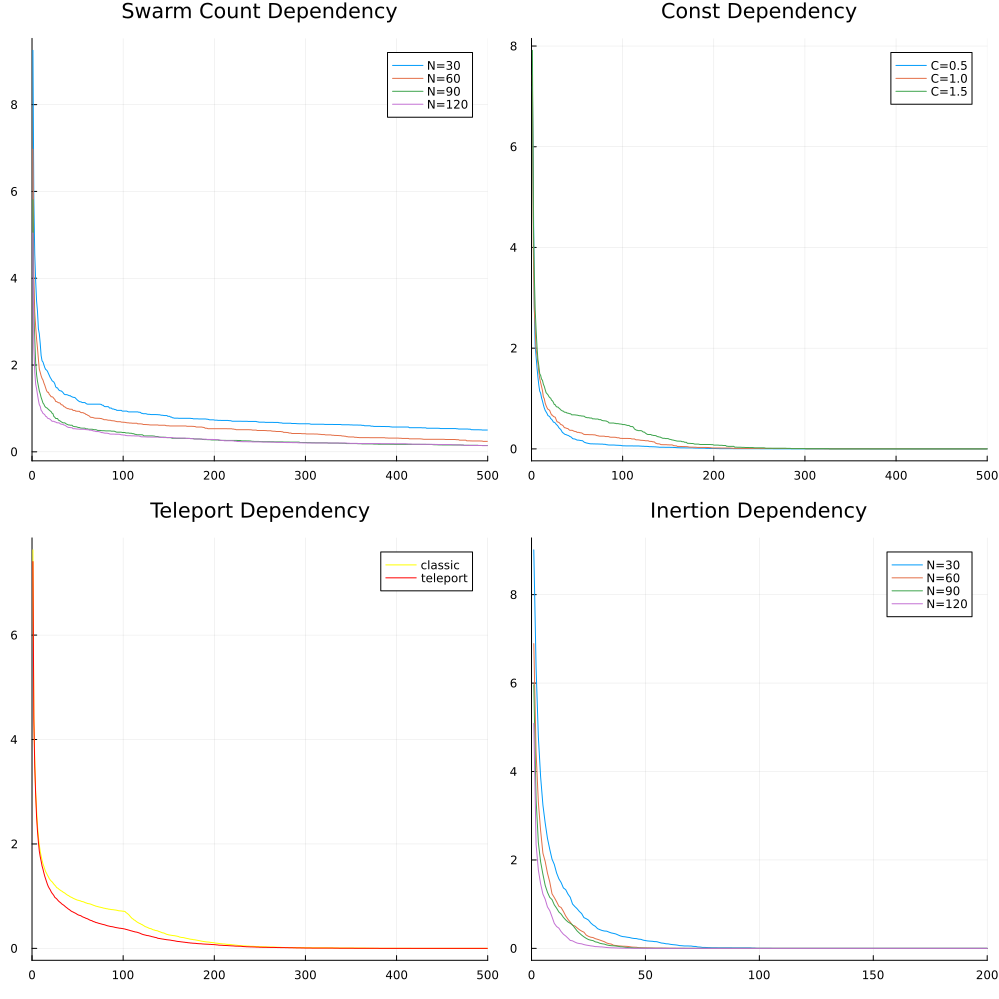

In [117]:
show_PSO(target_rastrygin, [-5., 5.])

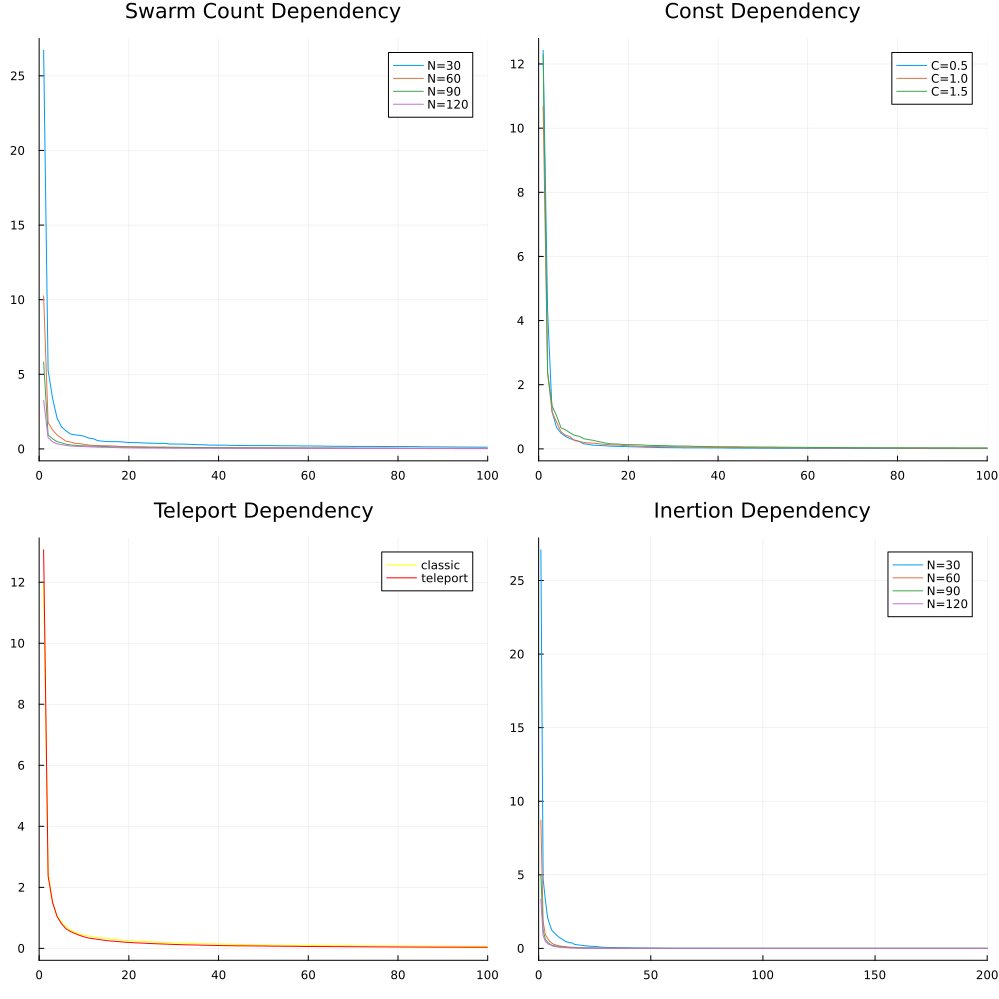

In [123]:
show_PSO(target_rosenbrock, [-5., 5.], xlims=[0,100])

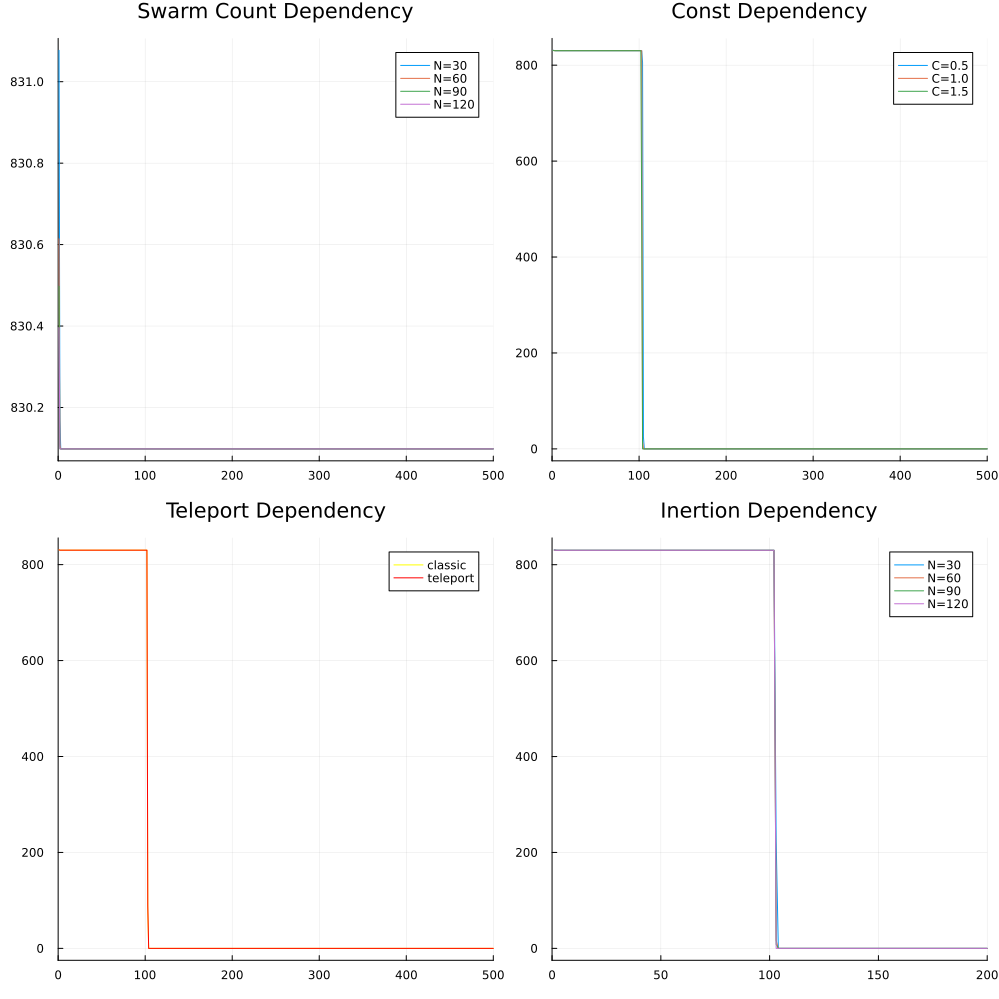

In [119]:
show_PSO(target_schefill, [-5., 5.])